In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import DocBin
import networkx as nx
import matplotlib.pyplot as plt
import os

from src import  utils

Load character names

In [2]:
char_df = pd.read_csv('data/char_name.csv')
# Removing the names inside brackets, making a new column with first names and removing duplicated names
import re

char_df['character'] = char_df['character'].apply(lambda x: re.sub(r'\(.*?\)', '', x))
char_df['char_firstname'] = char_df['character'].apply(lambda x: x.split(' ', 1)[0])
char_df.drop_duplicates(subset=['character'], inplace=True)

Load the books

In [3]:
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

Process the books using NER 

In [11]:
processed_books = []
for book in all_books:
    book_doc = utils.ner(book)
    book_ent = utils.get_ne_list_per_sentence(book_doc)
    processed_books.append(book_ent)



Saving the processed books

In [13]:
for i, df in enumerate(processed_books):
    df.to_csv(f'data/sent_ent_df_{i}.csv', index=False)

In [6]:
sent_entity_books = []

for book in processed_books[0]:
    book_ent = utils.get_ne_list_per_sentence(book)
    sent_entity_books.append(book_ent)


AttributeError: 'spacy.tokens.token.Token' object has no attribute 'sents'

Applying filter to extract the names and positions 

In [ ]:
# # Function to filter out the non-character entities

# def filter_entity(ent_list, char_df):
#     filtered_entities = []
#     for entity in ent_list:
#         # Check if entity exactly matches any DataFrame value after removing parentheses
#         if (char_df['character'] == entity).any() or \
#            (char_df['char_firstname'] == entity).any():
#             filtered_entities.append(entity)
#     return filtered_entities if filtered_entities else []
    

In [ ]:
# Applying the filter in the entire DF
sent_entity_df['char_ent'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, char_df))

In [ ]:
# Removing the empyt entities and getting only the first names
sent_entity_df_filtered =  sent_entity_df[sent_entity_df['char_ent'].map(len) > 0]
sent_entity_df_filtered['char_ent'] = sent_entity_df_filtered['char_ent'].apply(lambda x: [item.split()[0] for item in x])

C:\Users\Marlon\AppData\Local\Temp\ipykernel_620\3467692672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['char_ent'] = sent_entity_df_filtered['char_ent'].apply(lambda x: [item.split()[0] for item in x])


Creating relatioships

In [ ]:
# relationship = []

# for i in range(sent_entity_df_filtered.index[-1]):
#     end_i = min(i+5, sent_entity_df_filtered.index[-1])
#     char_list = sum((sent_entity_df_filtered.loc[i:end_i].char_ent), [])
#     # Remove duplciated char in the same sentence
#     char_unique = [char_list[i] for i in range(len(char_list))
#     if (i == 0 ) or char_list[i] != char_list[i-1]]

#     if len(char_unique) > 1:
#         for idx, a in enumerate(char_unique[:-1]):
#             b = char_unique[idx+1]
#             relationship.append({'source': a,'target': b})



In [ ]:
# relationship_df = pd.DataFrame(relationship)
# relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns= relationship_df.columns)

In [ ]:
# relationship_df['value'] = 1
# relationship_df = relationship_df.groupby(['source','target'], sort= False, as_index=False).sum()

Graph analysis and vizualization


In [ ]:
G = nx.from_pandas_edgelist(relationship_df, source='source', target='target', edge_attr='value', create_using=nx.Graph())

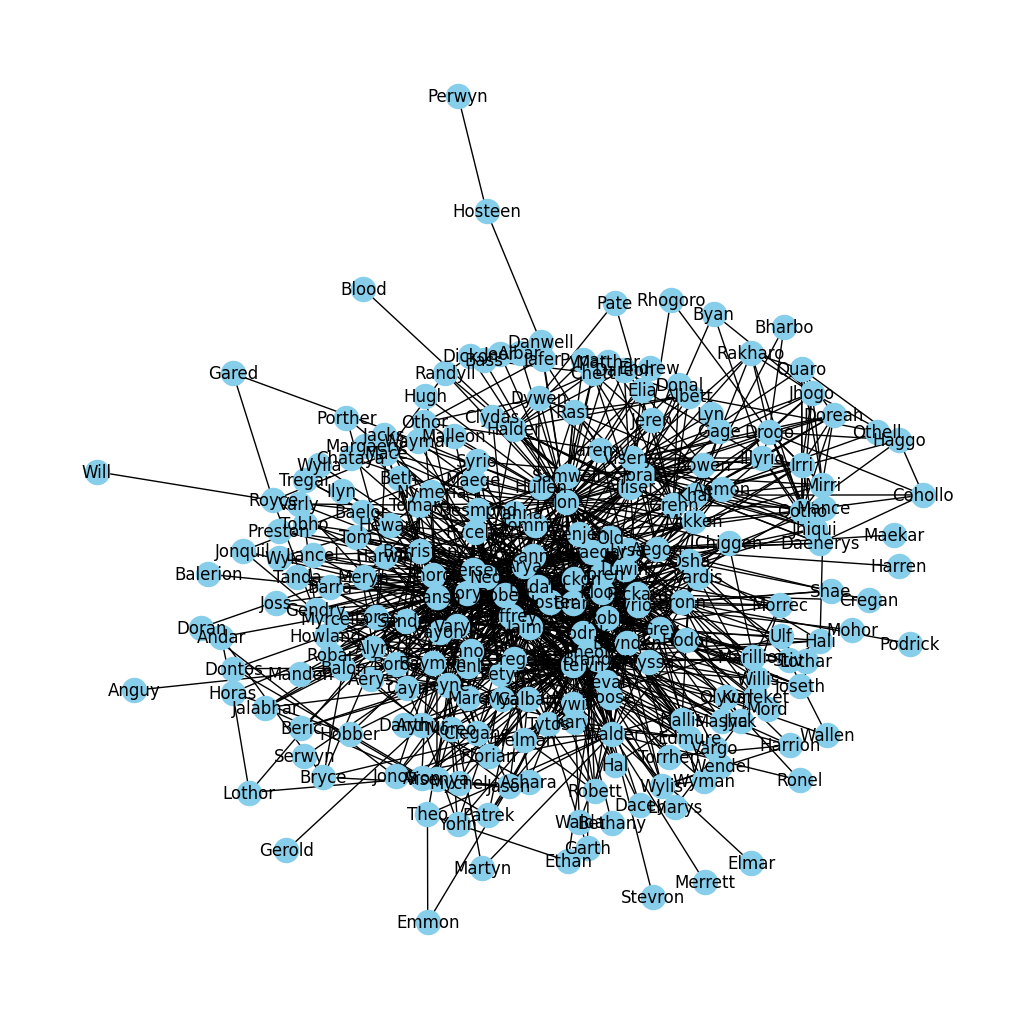

In [ ]:
# Graph vizualization - NetworkX
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)


Most important characters in GOT

<Axes: >

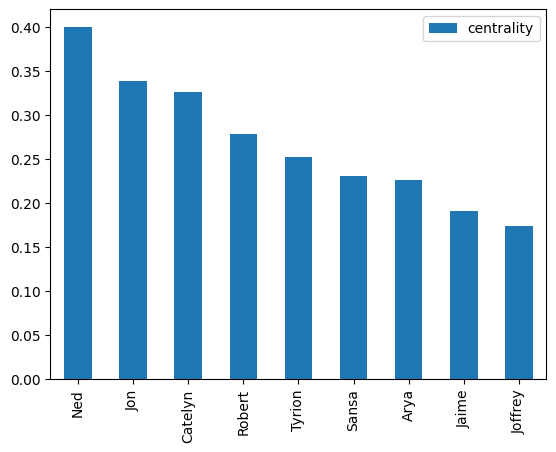

In [ ]:
# Degree of centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient= 'index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending = False)[0:9].plot(kind='bar')


<Axes: >

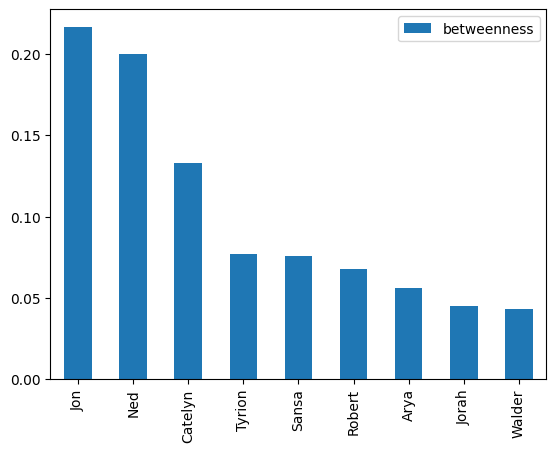

In [ ]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient= 'index', columns=['betweenness'])
# Plot top 10 nodes
betweenness_df.sort_values('betweenness', ascending = False)[0:9].plot(kind='bar')

<Axes: >

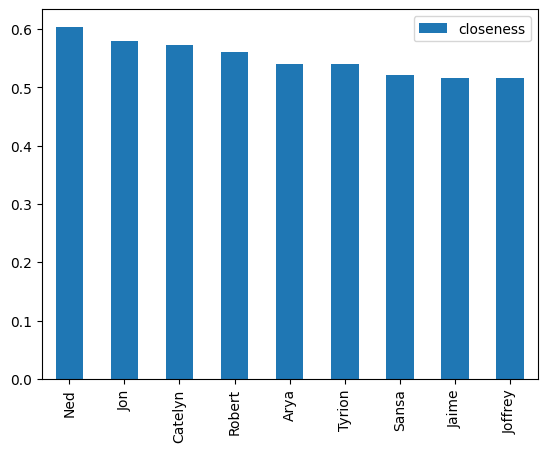

In [ ]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient= 'index', columns=['closeness'])
# Plot top 10 nodes
closeness_df.sort_values('closeness', ascending = False)[0:9].plot(kind='bar')

In [ ]:
# Saving centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

Community detection

In [ ]:
from community import community_louvain

communities= community_louvain.best_partition(G)

In [ ]:
nx.set_node_attributes(G, communities, 'group')

Graph vizualization - Pyvis

In [ ]:
from pyvis.network import Network
# Configure the Network object for inline display
net = Network( notebook=True, height='1000px', width='1300px', bgcolor='#222222', font_color='white')
net.from_nx(G)

net.set_options("""
const options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -25000
    },
    "minVelocity": 0.75
  }
}
""")

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.show('got.html')

import webbrowser
webbrowser.open('GOT.html')

got.html


True